# Random Forest Experiment on Relevance Prediction
### Chongye Feng, Haojie Hu
#### Aug, 2025

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("./data/training.csv")
print(train_df.head())
print(train_df.info())

   query_id  url_id  query_length  is_homepage  sig1  sig2  sig3  sig4  sig5  \
0      4631   28624             2            1  0.09  0.15  1288   352   376   
1      4631   28625             2            1  0.20  0.35  4662   337   666   
2      4631   28626             2            1  0.36  0.49  1121   385   270   
3      4631   28627             2            1  0.21  0.45  2925   478   640   
4      4631   28628             2            1  0.25  0.42  1328   429   412   

   sig6  sig7  sig8  relevance          id  
0    13  0.46  0.35          0  4631.28624  
1    28  0.43  0.27          1  4631.28625  
2    15  0.34  0.20          1  4631.28626  
3    14  0.44  0.33          1  4631.28627  
4    27  0.40  0.57          1  4631.28628  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80046 entries, 0 to 80045
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_id      80046 non-null  int64  
 1   url_id

In [5]:
print(train_df.describe())

           query_id         url_id  query_length   is_homepage          sig1  \
count  80046.000000   80046.000000  80046.000000  80046.000000  80046.000000   
mean   10862.069672   64219.328074      2.585826      0.268945      0.183240   
std     3586.767728   22522.930075      1.522094      0.443414      0.147354   
min     4631.000000      30.000000      1.000000      0.000000      0.000000   
25%     7756.000000   45386.250000      2.000000      0.000000      0.080000   
50%    10876.000000   64325.500000      2.000000      0.000000      0.150000   
75%    13950.000000   83446.000000      3.000000      1.000000      0.240000   
max    17038.000000  102816.000000     18.000000      1.000000      1.000000   

               sig2           sig3           sig4          sig5          sig6  \
count  80046.000000   80046.000000   80046.000000  80046.000000  80046.000000   
mean       0.346947    4857.078555     742.316256    550.527597     14.099155   
std        0.172545   23531.973200  

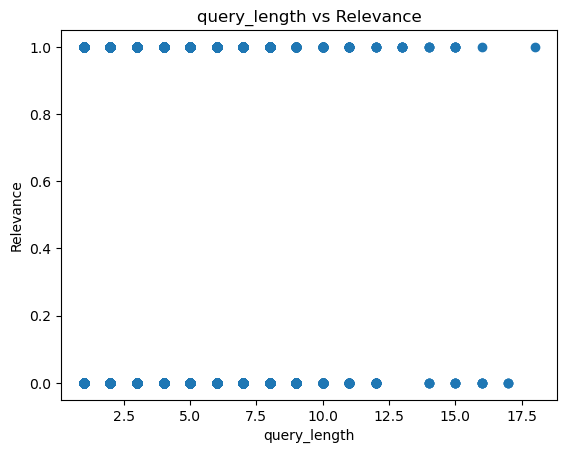

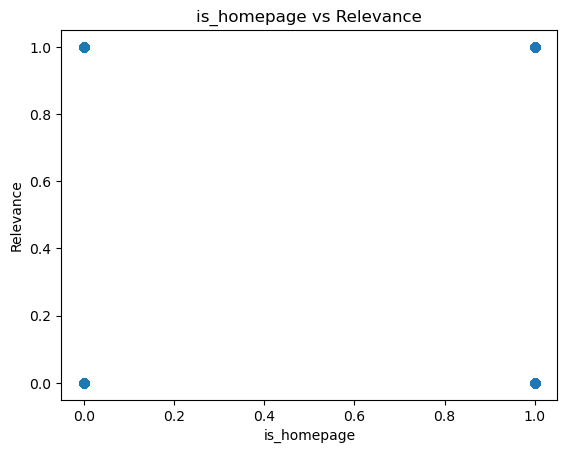

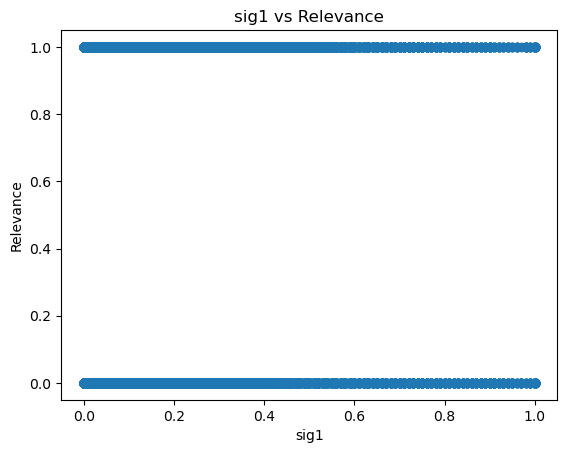

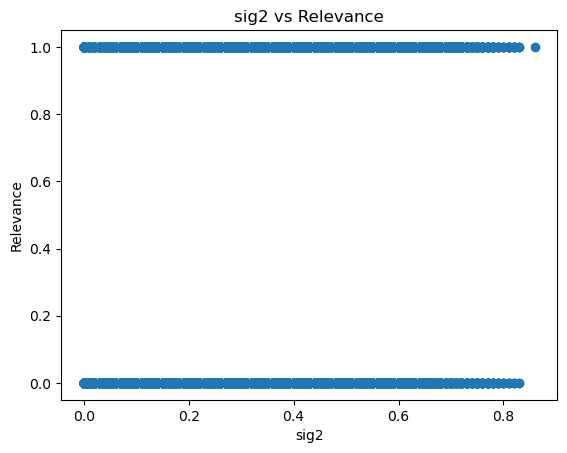

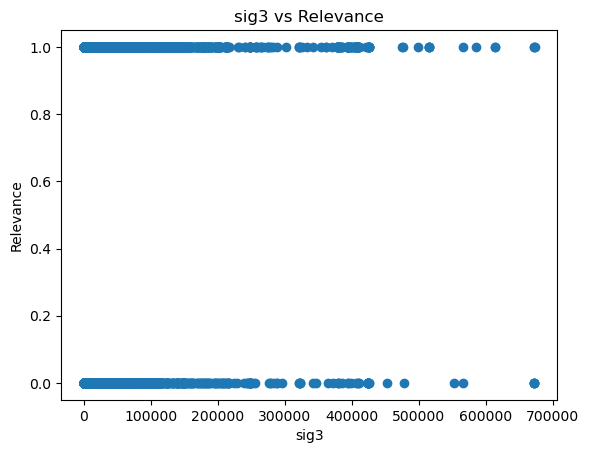

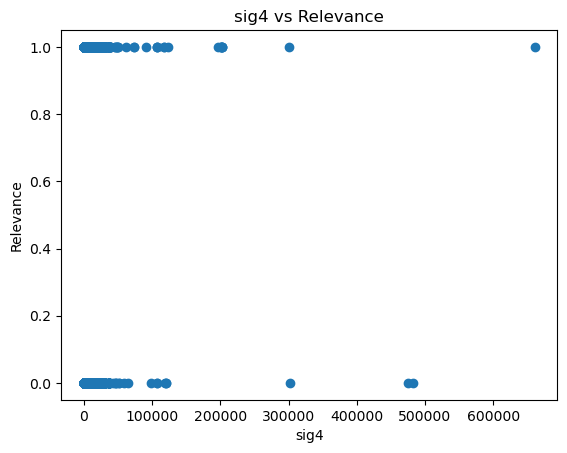

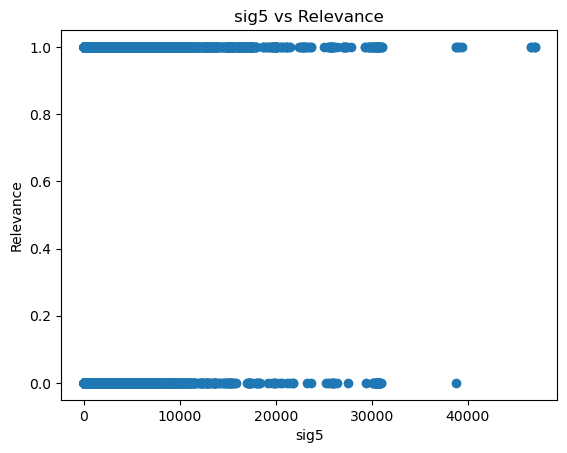

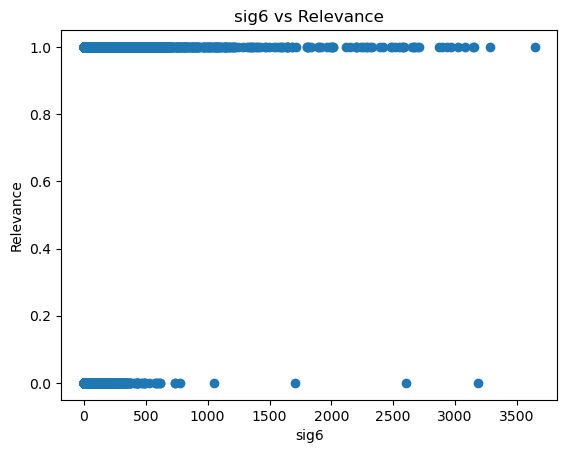

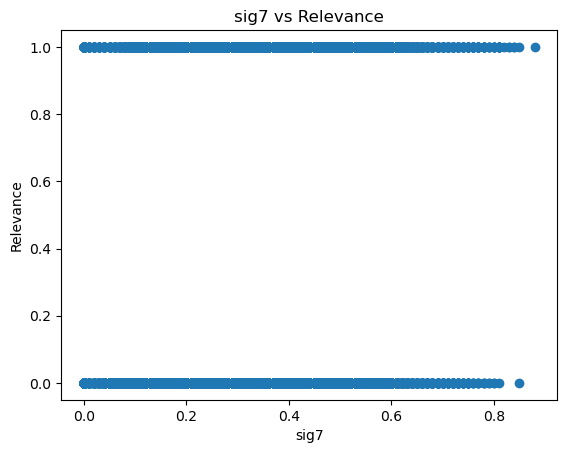

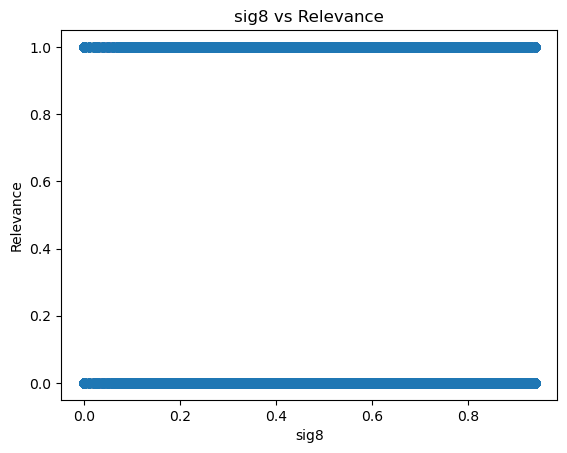

In [6]:
import matplotlib.pyplot as plt

for col in train_df.columns:
    if col not in ['relevance', 'id', 'query_id', 'url_id']:
        plt.scatter(train_df[col], train_df['relevance'])
        plt.xlabel(col)
        plt.ylabel('Relevance')
        plt.title(f'{col} vs Relevance')
        plt.show()


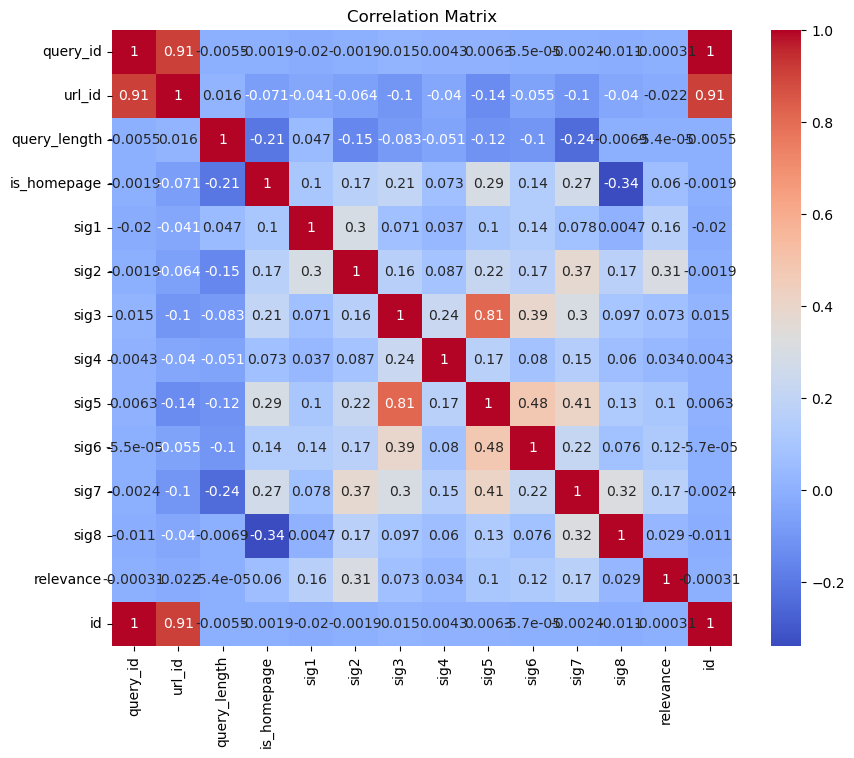

In [7]:
corr = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

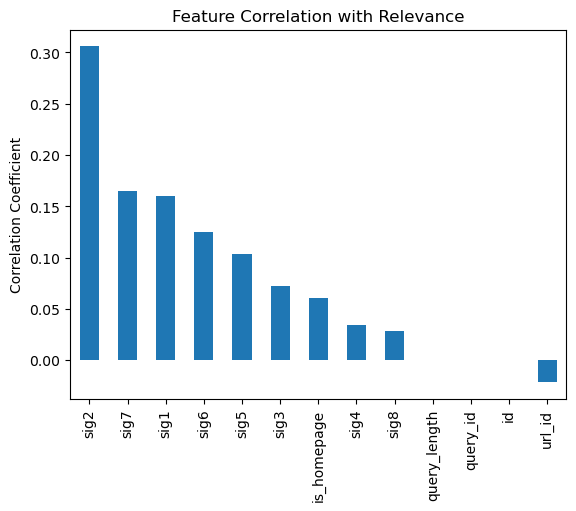

In [8]:
# Calculate correlation of each feature with 'relevance'
correlations = train_df.corr()['relevance'].drop('relevance')

# Plot as a bar chart
correlations.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Correlation with Relevance")
plt.ylabel("Correlation Coefficient")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

def rf_classification_pipeline(
    df,
    name_of_col_y='relevance',
    n_features=5,
    n_trees=100,
    drop_cols=None,
    random_state=42
):
    """
    Random Forest classification pipeline on a full dataframe, with custom drop columns.
    
    df: pd.DataFrame, input data (features + target)
    name_of_col_y: str, target column name
    n_features: int, number of top features to select
    n_trees: int, number of trees in Random Forest
    drop_cols: list or None, columns to drop from features (optional)
    random_state: int, random seed
    
    Returns:
        pipeline: fitted sklearn pipeline
        y_pred: predicted class labels on training data
        X: features DataFrame (after drop target and drop_cols)
        y: target labels (as integers)
    """
    # Columns to drop from features
    drop_cols = drop_cols if drop_cols is not None else []
    cols_to_drop = [name_of_col_y] + drop_cols
    
    # Separate features and target
    X = df.drop(columns=cols_to_drop)
    y = df[name_of_col_y]

    # Encode target to categorical if needed
    if not pd.api.types.is_integer_dtype(y):
        le = LabelEncoder()
        y = le.fit_transform(y)
    else:
        le = None
    
    # Detect feature types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    # Preprocessing
    numeric_transformer = SimpleImputer(strategy='median')
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    # Full pipeline
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('select', SelectKBest(f_classif, k=n_features)),
        ('rf', RandomForestClassifier(n_estimators=n_trees, random_state=random_state))
    ])
    
    # Fit and predict
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)
    
    return pipeline, y_pred, X, y, le  # le (LabelEncoder) for inverse_transform if needed

# Example usage:
# pipeline, y_pred, X, y, le = rf_classification_pipeline(
#     df, name_of_col_y='relevance', n_features=8, n_trees=200, drop_cols=['id', 'query_id', 'url_id'])


In [17]:
def treat_df(df, ignore_col_list, y_name):
    """
    Prepare features and target from df.
    Args:
        df (pd.DataFrame): input DataFrame
        ignore_col_list (list): columns to drop (besides y)
        y_name (str): target column name
    Returns:
        X (pd.DataFrame): feature matrix
        y (pd.Series): target vector
    """
    cols_to_drop = ignore_col_list + [y_name]
    X = df.drop(columns=cols_to_drop)
    y = df[y_name]
    return X, y


In [19]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_data = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    train_set = train_df.iloc[train_idx].copy()
    test_set = train_df.iloc[test_idx].copy()
    fold_data.append({
        'fold': fold_idx,
        'train_idx': train_idx,
        'test_idx': test_idx,
        'train_set': train_set,
        'test_set': test_set
    })
    # Optionally, save to CSV:
    train_set.to_csv(f'./data/fold_{fold_idx}_train.csv', index=False)
    test_set.to_csv(f'./data/fold_{fold_idx}_test.csv', index=False)


In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import combinations

# Your model pipeline from earlier
# from your_module import rf_classification_pipeline

# Experiment parameters
n_features_list = [3, 5, 8, 10, 12]
n_trees_list = [50, 100, 200, 300]
optional_ignore_cols = ['query_length', 'sig8', 'sig4', 'is_homepage']

# Generate all subsets of columns to ignore
ignore_col_list = [[]]
for i in range(1, len(optional_ignore_cols) + 1):
    ignore_col_list.extend(list(combinations(optional_ignore_cols, i)))

n_folds = 5
results = []

In [21]:
for fold in range(n_folds):
    # Load train/test for this fold
    train_df = pd.read_csv(f'data/fold_{fold}_train.csv')
    test_df = pd.read_csv(f'data/fold_{fold}_test.csv')

    for ignore_cols in ignore_col_list:
        ignore_cols = list(ignore_cols)
        drop_cols = ['id', 'query_id', 'url_id'] + ignore_cols

        for n_features in n_features_list:
            for n_trees in n_trees_list:
                # Train
                pipeline, y_pred_train, X_train, y_train, le = rf_classification_pipeline(
                    train_df,
                    name_of_col_y='relevance',
                    n_features=n_features,
                    n_trees=n_trees,
                    drop_cols=drop_cols
                )

                # Prepare test set features/labels
                X_test = test_df.drop(columns=drop_cols + ['relevance'])
                y_test = test_df['relevance']
                # Encode test labels if label encoder is used
                if le is not None:
                    y_test = le.transform(y_test)
                y_pred_test = pipeline.predict(X_test)

                train_acc = accuracy_score(y_train if le is None else le.transform(y_train), y_pred_train)
                test_acc = accuracy_score(y_test, y_pred_test)

                results.append({
                    'fold': fold,
                    'ignore_cols': ignore_cols.copy(),
                    'n_features': n_features,
                    'n_trees': n_trees,
                    'train_acc': train_acc,
                    'test_acc': test_acc
                })

                print(f"fold: {fold}, ignore: {ignore_cols}, n_features: {n_features}, n_trees: {n_trees}, "
                      f"train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}")


fold: 0, ignore: [], n_features: 3, n_trees: 50, train_acc: 0.8985, test_acc: 0.5858
fold: 0, ignore: [], n_features: 3, n_trees: 100, train_acc: 0.8988, test_acc: 0.5886
fold: 0, ignore: [], n_features: 3, n_trees: 200, train_acc: 0.8989, test_acc: 0.5904
fold: 0, ignore: [], n_features: 3, n_trees: 300, train_acc: 0.8989, test_acc: 0.5886
fold: 0, ignore: [], n_features: 5, n_trees: 50, train_acc: 0.9956, test_acc: 0.6190
fold: 0, ignore: [], n_features: 5, n_trees: 100, train_acc: 0.9959, test_acc: 0.6200
fold: 0, ignore: [], n_features: 5, n_trees: 200, train_acc: 0.9959, test_acc: 0.6224
fold: 0, ignore: [], n_features: 5, n_trees: 300, train_acc: 0.9959, test_acc: 0.6199
fold: 0, ignore: [], n_features: 8, n_trees: 50, train_acc: 0.9999, test_acc: 0.6377
fold: 0, ignore: [], n_features: 8, n_trees: 100, train_acc: 1.0000, test_acc: 0.6430
fold: 0, ignore: [], n_features: 8, n_trees: 200, train_acc: 1.0000, test_acc: 0.6429
fold: 0, ignore: [], n_features: 8, n_trees: 300, train_a

/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=10. All the features will be returned.
  warnings.warn(


fold: 0, ignore: [], n_features: 12, n_trees: 50, train_acc: 0.9999, test_acc: 0.6537


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=10. All the features will be returned.
  warnings.warn(


fold: 0, ignore: [], n_features: 12, n_trees: 100, train_acc: 1.0000, test_acc: 0.6544


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=10. All the features will be returned.
  warnings.warn(


fold: 0, ignore: [], n_features: 12, n_trees: 200, train_acc: 1.0000, test_acc: 0.6558


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=10. All the features will be returned.
  warnings.warn(


fold: 0, ignore: [], n_features: 12, n_trees: 300, train_acc: 1.0000, test_acc: 0.6572
fold: 0, ignore: ['query_length'], n_features: 3, n_trees: 50, train_acc: 0.8985, test_acc: 0.5858
fold: 0, ignore: ['query_length'], n_features: 3, n_trees: 100, train_acc: 0.8988, test_acc: 0.5886
fold: 0, ignore: ['query_length'], n_features: 3, n_trees: 200, train_acc: 0.8989, test_acc: 0.5904
fold: 0, ignore: ['query_length'], n_features: 3, n_trees: 300, train_acc: 0.8989, test_acc: 0.5886
fold: 0, ignore: ['query_length'], n_features: 5, n_trees: 50, train_acc: 0.9956, test_acc: 0.6190
fold: 0, ignore: ['query_length'], n_features: 5, n_trees: 100, train_acc: 0.9959, test_acc: 0.6200
fold: 0, ignore: ['query_length'], n_features: 5, n_trees: 200, train_acc: 0.9959, test_acc: 0.6224
fold: 0, ignore: ['query_length'], n_features: 5, n_trees: 300, train_acc: 0.9959, test_acc: 0.6199
fold: 0, ignore: ['query_length'], n_features: 8, n_trees: 50, train_acc: 0.9999, test_acc: 0.6377
fold: 0, ignore:

/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 10, n_trees: 50, train_acc: 0.9998, test_acc: 0.6385


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 10, n_trees: 100, train_acc: 1.0000, test_acc: 0.6445


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 10, n_trees: 200, train_acc: 1.0000, test_acc: 0.6474


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 10, n_trees: 300, train_acc: 1.0000, test_acc: 0.6494


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 12, n_trees: 50, train_acc: 0.9998, test_acc: 0.6385


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 12, n_trees: 100, train_acc: 1.0000, test_acc: 0.6445


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 12, n_trees: 200, train_acc: 1.0000, test_acc: 0.6474


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=12 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['query_length'], n_features: 12, n_trees: 300, train_acc: 1.0000, test_acc: 0.6494
fold: 0, ignore: ['sig8'], n_features: 3, n_trees: 50, train_acc: 0.8985, test_acc: 0.5858
fold: 0, ignore: ['sig8'], n_features: 3, n_trees: 100, train_acc: 0.8988, test_acc: 0.5886
fold: 0, ignore: ['sig8'], n_features: 3, n_trees: 200, train_acc: 0.8989, test_acc: 0.5904
fold: 0, ignore: ['sig8'], n_features: 3, n_trees: 300, train_acc: 0.8989, test_acc: 0.5886
fold: 0, ignore: ['sig8'], n_features: 5, n_trees: 50, train_acc: 0.9956, test_acc: 0.6190
fold: 0, ignore: ['sig8'], n_features: 5, n_trees: 100, train_acc: 0.9959, test_acc: 0.6200
fold: 0, ignore: ['sig8'], n_features: 5, n_trees: 200, train_acc: 0.9959, test_acc: 0.6224
fold: 0, ignore: ['sig8'], n_features: 5, n_trees: 300, train_acc: 0.9959, test_acc: 0.6199
fold: 0, ignore: ['sig8'], n_features: 8, n_trees: 50, train_acc: 0.9999, test_acc: 0.6377
fold: 0, ignore: ['sig8'], n_features: 8, n_trees: 100, train_acc: 1.0000,

/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['sig8'], n_features: 10, n_trees: 50, train_acc: 0.9998, test_acc: 0.6446


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


fold: 0, ignore: ['sig8'], n_features: 10, n_trees: 100, train_acc: 1.0000, test_acc: 0.6467


/home/chongyef/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


KeyboardInterrupt: 